In [5]:
from scipy import ndimage
import matplotlib.pyplot as plt
from filter import *
from segment_graph import *
import time
import cv2

def plot_ims(data, alpha=True, cmap=None, ncols=None, nrows=None, ): # plot_images(12)
    """
    Expects numpy array with channels last or list
    """
    if not nrows: nrows = 1
    
    if type(data) == list:
#         nrows = 1
        if not ncols: ncols = len(data)
    else:
        if len(data.shape[:1]) == 3: ncols = 1
        else: ncols = data.shape[0] // nrows
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(11, 10)
    fig.tight_layout()
    
    for i, ax in enumerate(axes.flat):
        if len(data[i].shape) == 2: 
            data_ = data[i].astype(np.uint8)
            im = ax.imshow(data_, cmap=cmap)
        elif (data[i].shape[2] == 4):
            if alpha: 
                data_ = data[i].astype(np.uint8)
                im = ax.imshow(data_[:,:,[2,1,0,3]], cmap=cmap)
            else: 
                data_ = data[i].astype(np.uint8)
                im = ax.imshow(data_[:,:,[2,1,0]], cmap=cmap)
        elif (data[i].shape[2] == 3): 
            data_ = data[i].astype(np.uint8)
            im = ax.imshow(data_[:,:,[2,1,0]], cmap=cmap)
        else: 
            print('Data dimensions not supported')
        
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
    plt.subplots_adjust(left=0, hspace=0, wspace=0)
#     plt.tight_layout()
    plt.show()

# --------------------------------------------------------------------------------
# Segment an image:
# Returns a color image representing the segmentation.
#
# Inputs:
#           in_image: image to segment.
#           sigma: to smooth the image.
#           k: constant for threshold function.
#           min_size: minimum component size (enforced by post-processing stage).
#
# Returns:
#           num_ccs: number of connected components in the segmentation.
# --------------------------------------------------------------------------------

def segment(in_image, sigma, k, min_size):
    start_time = time.time()
    height, width, band = in_image.shape
    print("Height:  " + str(height))
    print("Width:   " + str(width))
    smooth_red_band = smooth(in_image[:, :, 0], sigma)
    smooth_green_band = smooth(in_image[:, :, 1], sigma)
    smooth_blue_band = smooth(in_image[:, :, 2], sigma)

    # build graph
    edges_size = width * height * 4
    edges = np.zeros(shape=(edges_size, 3), dtype=object)
    num = 0
    for y in range(height):
        for x in range(width):
            if x < width - 1:
                edges[num, 0] = int(y * width + x)
                edges[num, 1] = int(y * width + (x + 1))
                edges[num, 2] = diff(smooth_red_band, smooth_green_band, smooth_blue_band, x, y, x + 1, y)
                num += 1
            if y < height - 1:
                edges[num, 0] = int(y * width + x)
                edges[num, 1] = int((y + 1) * width + x)
                edges[num, 2] = diff(smooth_red_band, smooth_green_band, smooth_blue_band, x, y, x, y + 1)
                num += 1

            if (x < width - 1) and (y < height - 2):
                edges[num, 0] = int(y * width + x)
                edges[num, 1] = int((y + 1) * width + (x + 1))
                edges[num, 2] = diff(smooth_red_band, smooth_green_band, smooth_blue_band, x, y, x + 1, y + 1)
                num += 1

            if (x < width - 1) and (y > 0):
                edges[num, 0] = int(y * width + x)
                edges[num, 1] = int((y - 1) * width + (x + 1))
                edges[num, 2] = diff(smooth_red_band, smooth_green_band, smooth_blue_band, x, y, x + 1, y - 1)
                num += 1
    # Segment
    u = segment_graph(width * height, num, edges, k)

    # post process small components
    for i in range(num):
        a = u.find(edges[i, 0])
        b = u.find(edges[i, 1])
        if (a != b) and ((u.size(a) < min_size) or (u.size(b) < min_size)):
            u.join(a, b)

    num_cc = u.num_sets()
    output = np.zeros(shape=(height, width, 3))

    # pick random colors for each component
    colors = np.zeros(shape=(height * width, 3))
    for i in range(height * width):
        colors[i, :] = random_rgb()

    for y in range(height):
        for x in range(width):
            comp = u.find(y * width + x)
            output[y, x, :] = colors[comp, :]

    elapsed_time = time.time() - start_time
    print(
        "Execution time: " + str(int(elapsed_time / 60)) + " minute(s) and " + str(
            int(elapsed_time % 60)) + " seconds")

#     # displaying the result
#     fig = plt.figure()
#     a = fig.add_subplot(1, 2, 1)
#     plt.imshow(in_image)
#     a.set_title('Original Image')
#     a = fig.add_subplot(1, 2, 2)
#     plt.imshow(output.astype('int'))
#     a.set_title('Segmented Image')
#     plt.show()

    return in_image, output

In [6]:
if __name__ == "__main__":
    
    sigma = 0.5
    k = 500
    min = 50
    input_path = "data/paris.jpg"

    # Loading the image
    input_image = ndimage.imread(input_path, flatten=False, mode=None)
#     input_image = cv2.imread(input_path)

    print("Loading is done.")
    print("processing...")
    in_im, output = segment(input_image, sigma, k, min)

Loading is done.
processing...
Height:  720
Width:   480
Execution time: 0 minute(s) and 31 seconds


Height:  286
Width:   114
Execution time: 0 minute(s) and 2 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Blowhole/Imgs/exp3_num_4978.png


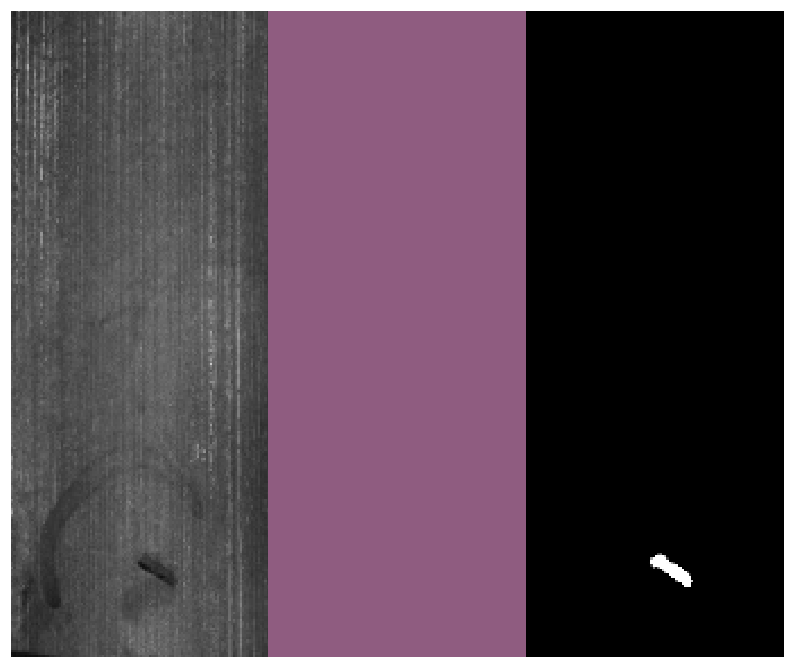

Height:  276
Width:   125
Execution time: 0 minute(s) and 3 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Blowhole/Imgs/exp6_num_54366.png


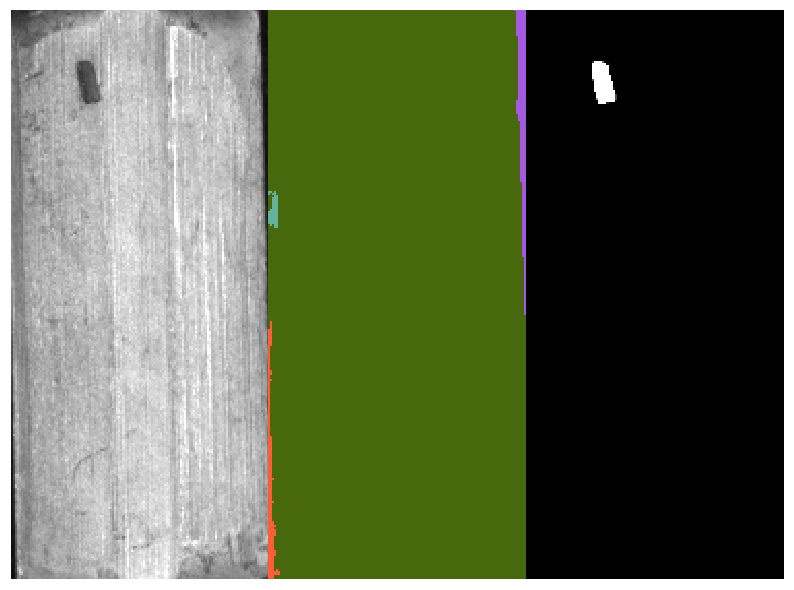

Height:  371
Width:   504
Execution time: 0 minute(s) and 18 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Blowhole/Imgs/exp1_num_346311.png


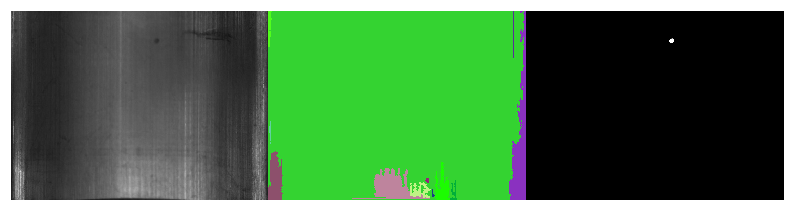

Height:  289
Width:   118
Execution time: 0 minute(s) and 3 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Blowhole/Imgs/exp6_num_40515.png


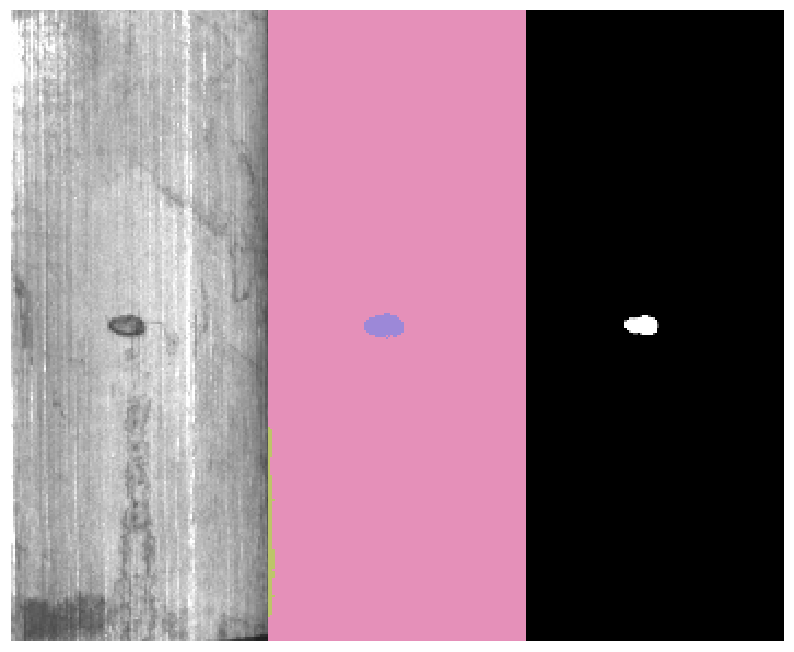

Height:  268
Width:   221
Execution time: 0 minute(s) and 5 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Blowhole/Imgs/exp3_num_297506.png


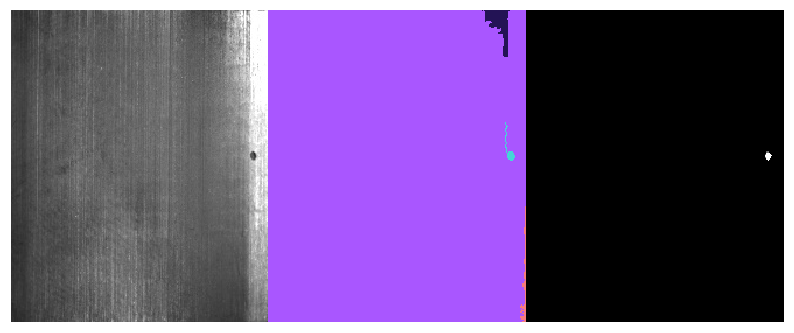

Height:  271
Width:   218
Execution time: 0 minute(s) and 5 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Blowhole/Imgs/exp6_num_297601.png


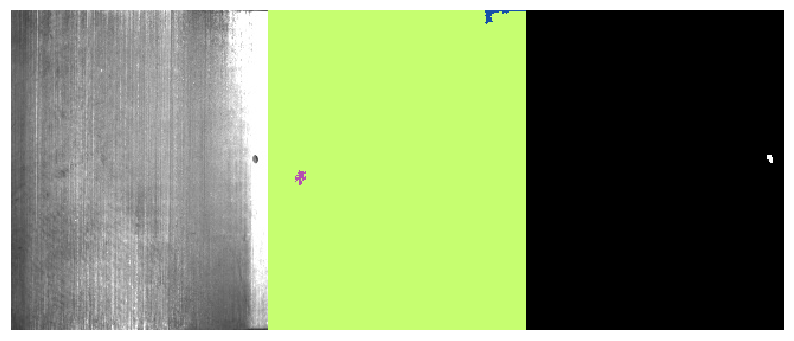

Height:  386
Width:   433
Execution time: 0 minute(s) and 14 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Blowhole/Imgs/exp4_num_9520.png


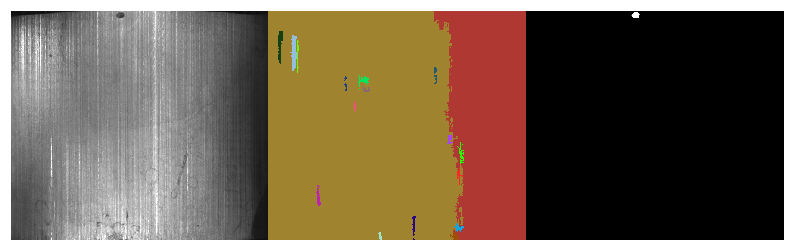

Height:  382
Width:   456
Execution time: 0 minute(s) and 16 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Blowhole/Imgs/exp1_num_9473.png


Height:  287
Width:   120
Execution time: 0 minute(s) and 3 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Blowhole/Imgs/exp4_num_36258.png


Height:  351
Width:   356
Execution time: 0 minute(s) and 11 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Blowhole/Imgs/exp2_num_327997.png


In [8]:
import glob
path = '../data/Magnetic-tile-defect-datasets.-master/MT_Blowhole/Imgs/'
ims = glob.glob(path + '*.jpg')
for i in ims[:10]:
    # Loading the image
    im = cv2.imread(i)
    _input, output = segment(im, sigma=0.5, k=500, min_size=50)
    label_path = path + i.split('/')[-1].split('.jpg')[0] + '.png'
    print(label_path)
    label = cv2.imread(label_path)
    plot_ims([_input, output, label])

In [14]:
def iou(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    
    return iou_score

In [16]:
plot_ims([_input, label])

/root/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [10]:
np.unique(output)

array([  12.,   28.,   34.,   62.,   80.,  104.,  116.,  124.,  125.,
        129.,  172.,  177.,  185.,  204.,  211.,  215.,  218.,  229.])

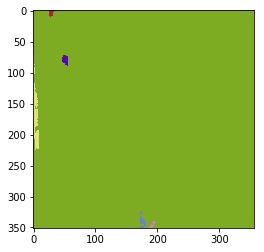

In [13]:
plt.imshow(output.astype('int'))

In [18]:
np.unique(label[:,:,0])

array([  0,   1,   3,  30,  31,  33,  44,  45,  46,  52, 145, 148, 149,
       154, 241, 242, 246, 249, 255], dtype=uint8)

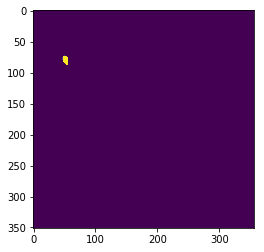

In [17]:
plt.imshow(label[:,:,0].astype('int'))

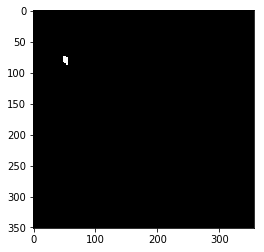

In [38]:
np.unique(label[:,:,2])
mask = label == 255
mask = mask.astype(int) * 255
plt.imshow(mask)

In [42]:
np.unique(mask)

array([  0, 255])

Height:  354
Width:   244
Execution time: 0 minute(s) and 7 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Uneven/Imgs/exp2_num_129056.png


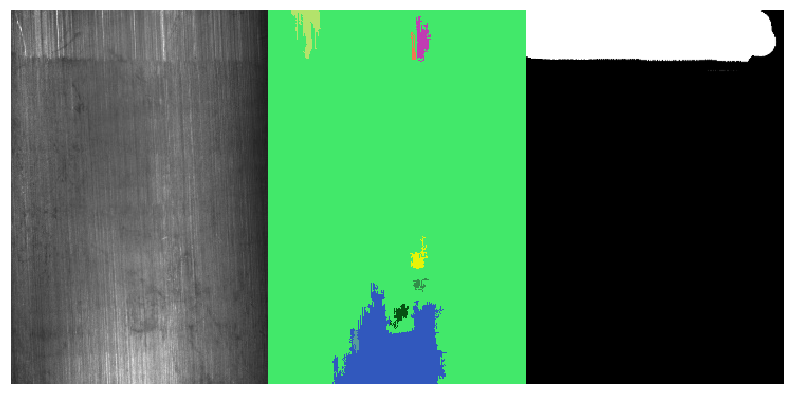

Height:  279
Width:   219
Execution time: 0 minute(s) and 4 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Uneven/Imgs/exp2_num_311834.png


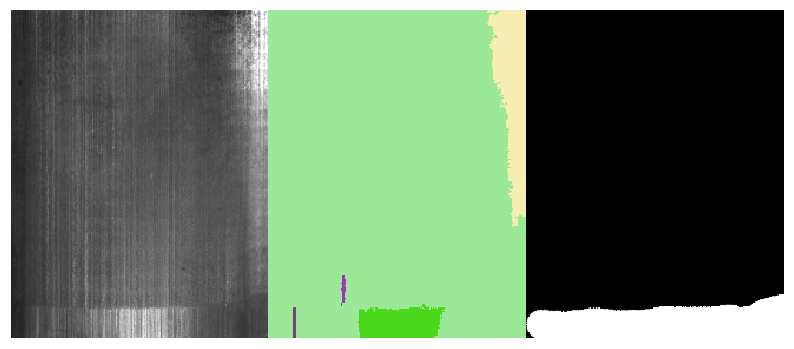

Height:  277
Width:   230
Execution time: 0 minute(s) and 5 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Uneven/Imgs/exp3_num_274138.png


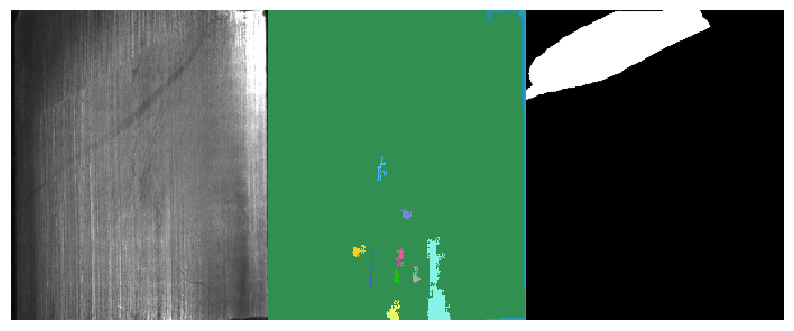

Height:  328
Width:   188
Execution time: 0 minute(s) and 5 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Uneven/Imgs/exp5_num_172332.png


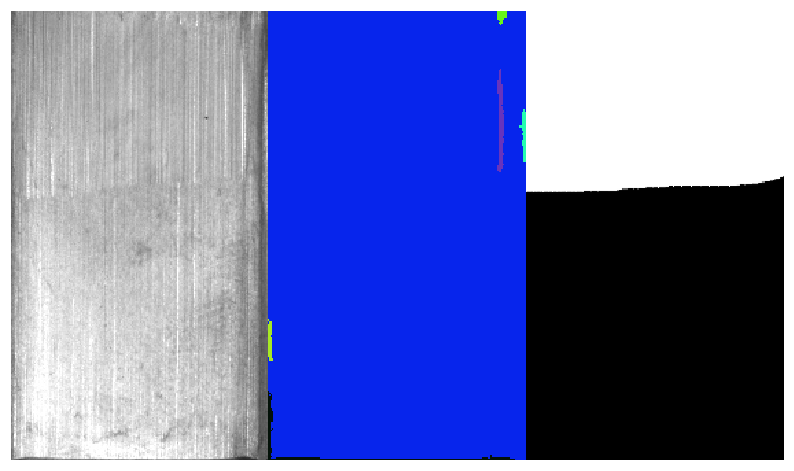

Height:  312
Width:   190
Execution time: 0 minute(s) and 5 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Uneven/Imgs/exp1_num_186826.png


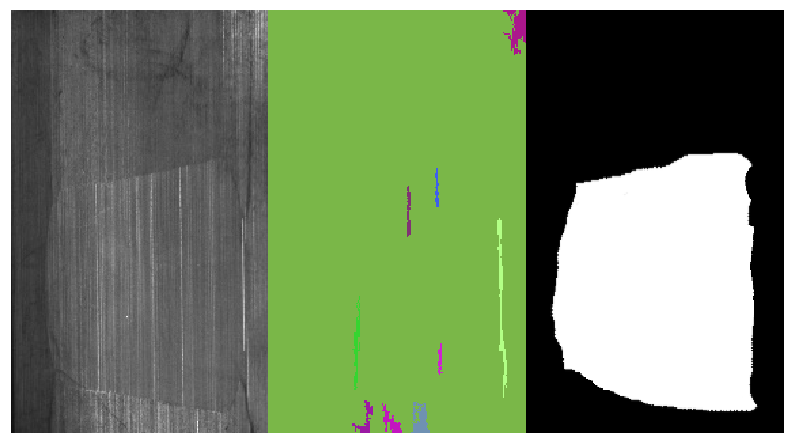

Height:  259
Width:   602
Execution time: 0 minute(s) and 13 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Uneven/Imgs/exp3_num_124629.png


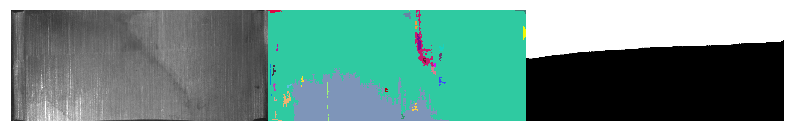

Height:  309
Width:   191
Execution time: 0 minute(s) and 5 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Uneven/Imgs/exp4_num_186909.png


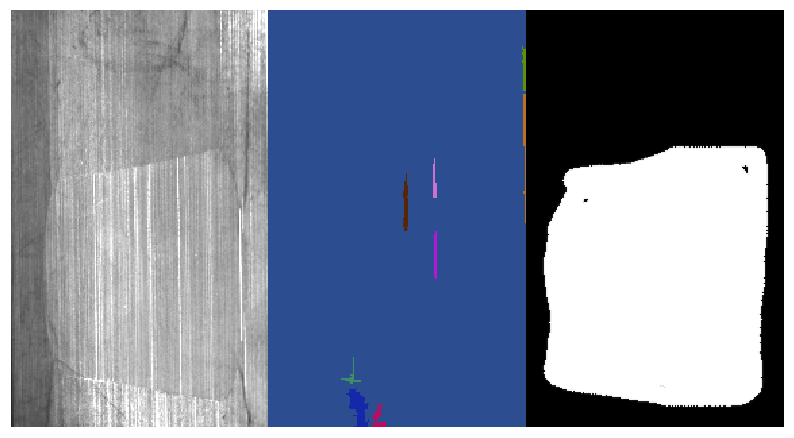

Height:  332
Width:   514
Execution time: 0 minute(s) and 14 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Uneven/Imgs/exp6_num_25007.png


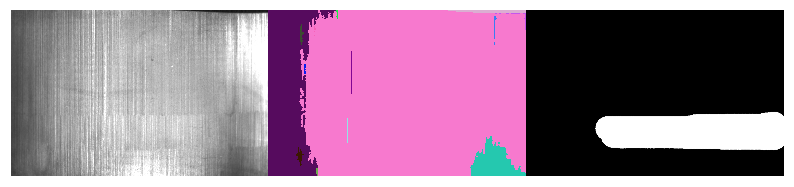

Height:  327
Width:   502
Execution time: 0 minute(s) and 14 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Uneven/Imgs/exp5_num_45084.png


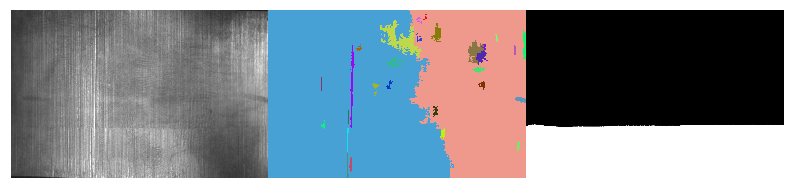

Height:  292
Width:   124
Execution time: 0 minute(s) and 3 seconds
../data/Magnetic-tile-defect-datasets.-master/MT_Uneven/Imgs/exp5_num_592.png


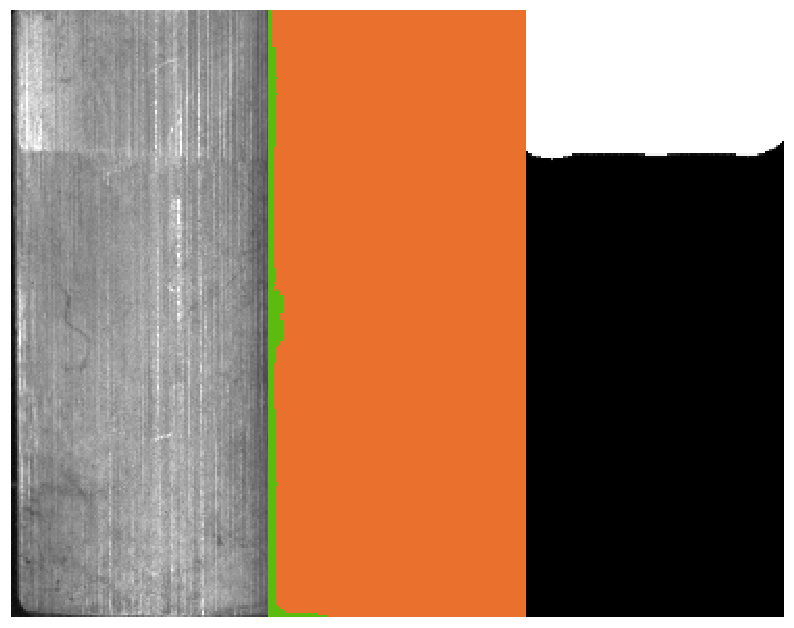

In [43]:
path = '../data/Magnetic-tile-defect-datasets.-master/MT_Uneven/Imgs/'
ims = glob.glob(path + '*.jpg')
for i in ims[:10]:
    # Loading the image
    im = cv2.imread(i)
    _input, output = segment(im, sigma=0.5, k=500, min_size=50)
    label_path = path + i.split('/')[-1].split('.jpg')[0] + '.png'
    print(label_path)
    label = cv2.imread(label_path)
    plot_ims([_input, output, label])